# Sentiment analysis: *Amazon fine food review*

## Introduction

### 👨‍🎓 Group members 👨‍🎓

* Kiselov Nikita 
* Mashra Marwan 

### Presentation

* The project is based on the Amazon food review from customers dataset
* The original Kaggle competition was to predict whether a review was positive or negative
* In this project, we will add the **neural** level
* You will try to **predict the 3 classes** given by the user according to their **review**
* For this, you will need to use at least 2 **sentence embeddings techniques** (e.g., Word2Vec, BERT)
* The primary metric we will focus on is the **macro-averaged f1-score**
* The dataset contains more than 500K reviews

### Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code (do not forget to **cite** code you reuse, or it will be considered plagiarism)

* **4 points**: Modeling and feature extractions

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### Download the data

https://www.kaggle.com/snap/amazon-fine-food-reviews/download

(254MB)

In [1]:
import re
from pathlib import Path

import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from sklearn import (
    decomposition,
    ensemble,
    feature_extraction,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from plotly.offline import iplot
import plotly.graph_objs as go
from sklearn.manifold import TSNE
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression



In [2]:
sns.set_style("darkgrid")
sns.set_context("notebook")

nltk.download('punkt')

tqdm.pandas()
nltk.download('stopwords')

%config InlineBackend.figure_format="retina"  # For high DPI display

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marwa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marwa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
DATA = Path("./archive-amazon")

assert DATA.is_dir()

IMG = Path("./images")

assert IMG.is_dir()


## Exploration

### Read Data

In [4]:
pd.read_csv(DATA / "Reviews.csv").shape, pd.read_csv(DATA / "Reviews_small.csv").shape


((568454, 10), (394970, 4))

In [5]:
df = pd.read_csv(DATA / "Reviews_small.csv", index_col=0)
df.head()


,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


* Contains some product, user, and review information

* Data used here:

    * **Text**: Complete product review by the customer
    * **Summary**: Summary proposed by the customer
    * **Score**: The product rating provided by the customer

### Distribution of the variable ***Score***

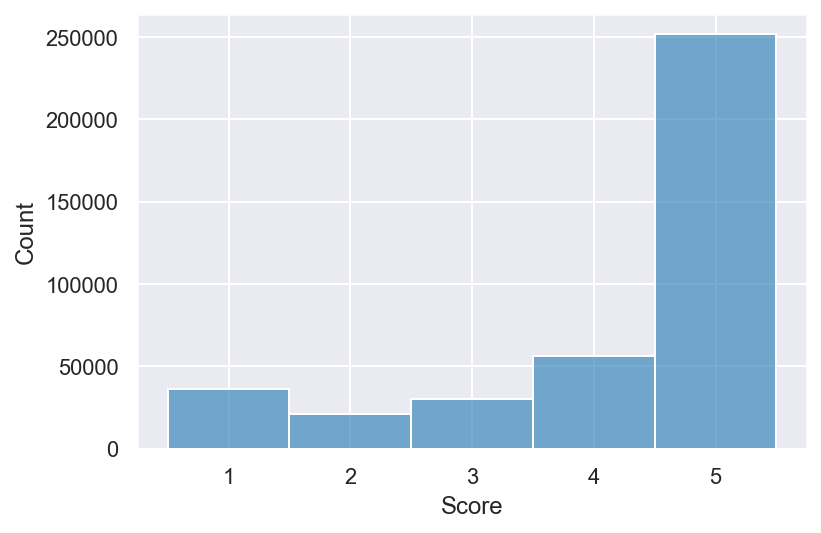

In [6]:
sns.histplot(df, x="Score", alpha=0.6, discrete=True)
plt.show()


* Most of the customer rating is positive 

### Analysis of binary and 3-classes versions

* Convert the 5-classes rating in 3-classes sentiment as a target variable
* Positive reviews will be classified as +1, neutral 0, and negative, -1
* The rating value 3 will be used as threshold

In [7]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 1
    if rating < threshold:
        return -1
    return 0


In [8]:
df["sentiment"] = df.Score.map(convert_rating)


Histogram of transfromed labels

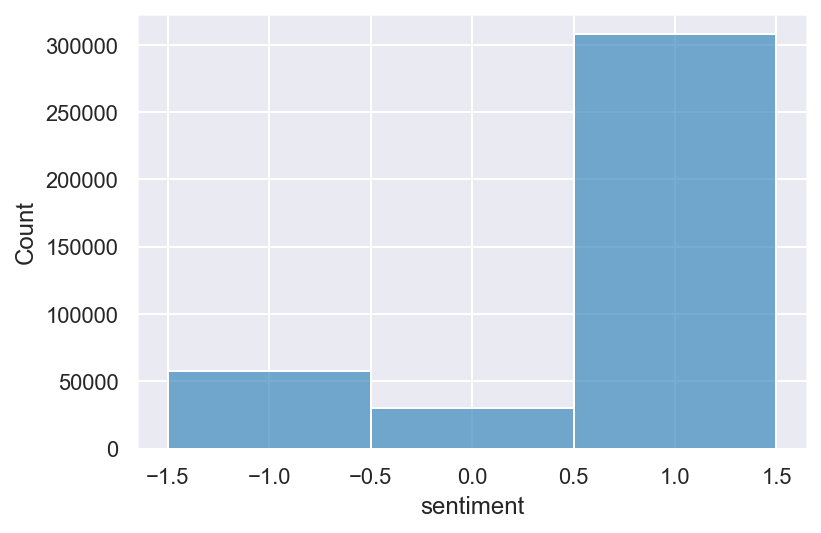

In [9]:
sns.histplot(df, x="sentiment", alpha=0.6, discrete=True)
plt.show()


### Words distribution

Let's observe the most frequent words for positive and negative reviews through **word clouds**

In [10]:
# Create stopword list

diff_stopwords = set(wordcloud.STOPWORDS) ^ set(nltk.corpus.stopwords.words("english"))
print(len(diff_stopwords))

stopwords = set(wordcloud.STOPWORDS) | set(nltk.corpus.stopwords.words("english"))
stopwords.update(["br", "href"])

print(len(stopwords))


83
229


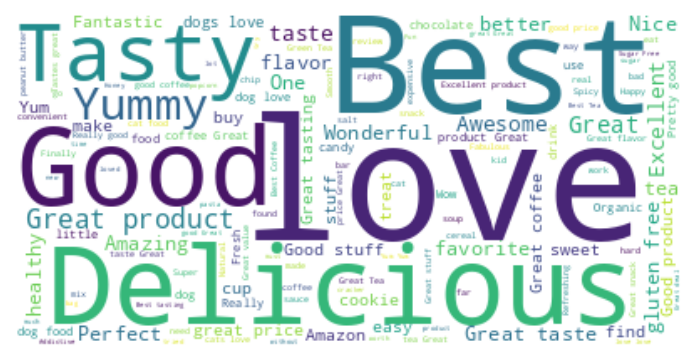

In [11]:
positive_df = df[df.sentiment == 1]

pos_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(positive_df.Summary.dropna()))

plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "pos_wordcloud.png")
plt.show()


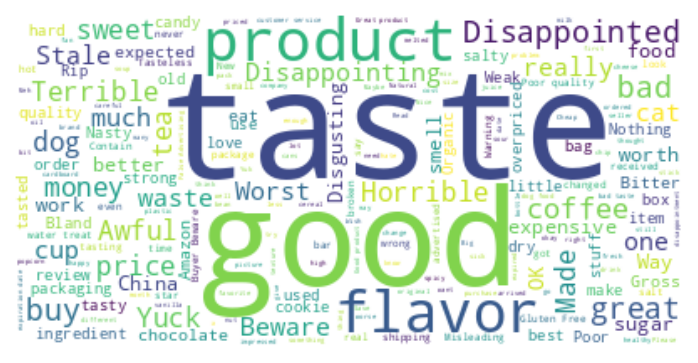

In [12]:
negative_df = df[df.sentiment == -1]

neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(negative_df.Summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "neg_wordcloud.png")
plt.show()


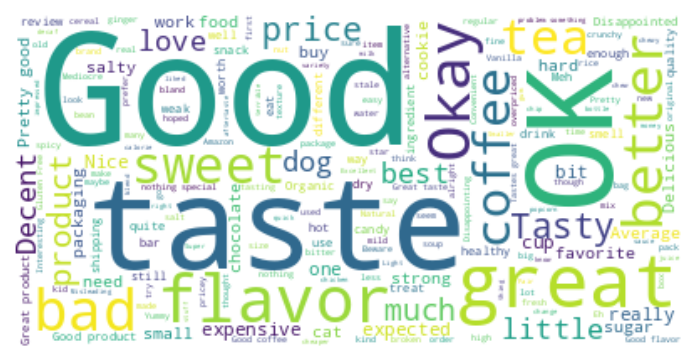

In [13]:
neutral_df = df[df.sentiment == 0]

neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(neutral_df.Summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "neutr_wordcloud.png")
plt.show()


* Positive sentiment words, e.g., *love, best, delicious*

* Negative sentiment words, e.g., *disappointed, bad, yuck*

* The word ***good*** appears in the negative sentiment word cloud, despite being a positive word 

    * Probably because it was used in a negative context: ***not good*** 

* Word **OK** apperas the most in the neutral sentiment word cloud

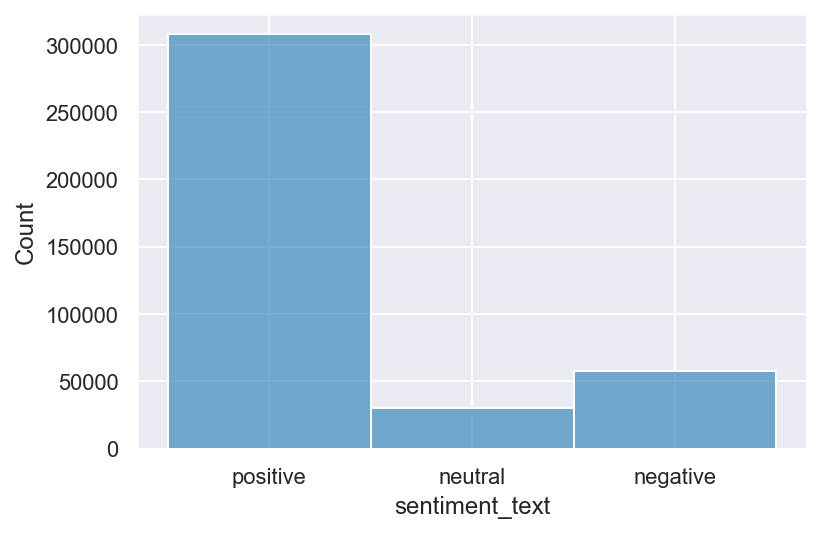

In [14]:
df["sentiment_text"] = (
    df.sentiment.replace({-1: "negative", 0: "neutral", 1: "positive"})
    .astype("category")  # To set the x-axis order in sns.histplot
    .cat.reorder_categories(["positive", "neutral", "negative"])
)

sns.histplot(
    df,
    x="sentiment_text",
    alpha=0.6,
    discrete=True,
)
plt.show()


## Simple analysis

In [87]:
df_tokens = df.copy().dropna()
df_tokens["tokens_summary"] = df_tokens["Summary"].map(word_tokenize)
df_tokens["tokens_text"] = df_tokens["Text"].map(word_tokenize)

df_tokens["nb_tokens_summary"] = df_tokens["tokens_summary"].map(len)
df_tokens["nb_tokens_text"] = df_tokens["tokens_text"].map(len)


Average number of words:
 Summary: 4 words
 Text: 95 words
Max number of words:
 Summary: 81 words
 Text: 4145 words


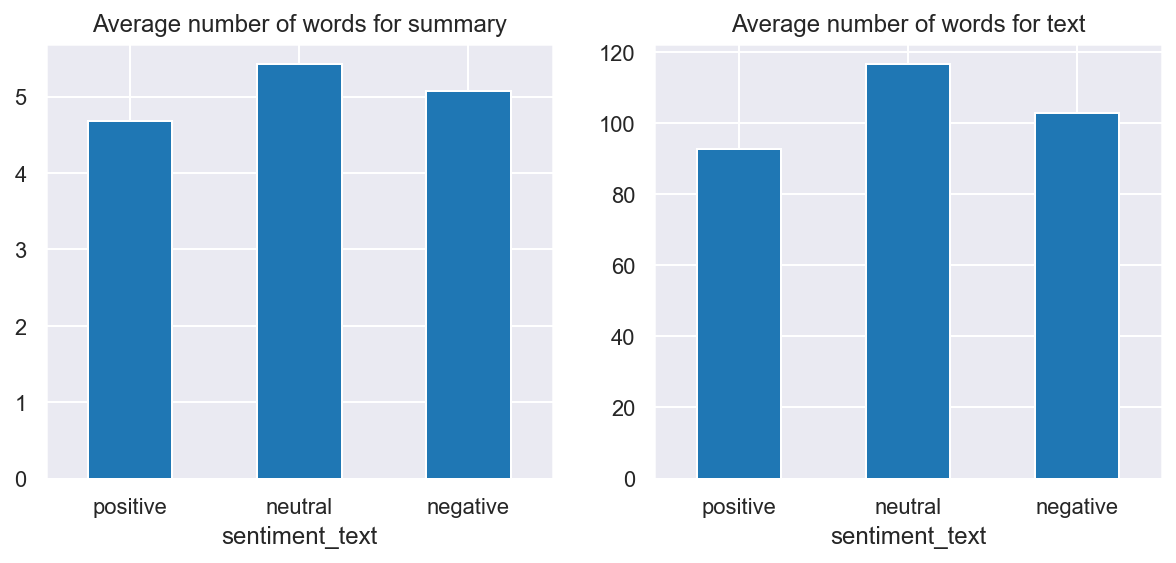

In [88]:
print(
    f"Average number of words:\n Summary: {int(df_tokens['nb_tokens_summary'].mean())} words\n Text: {int(df_tokens['nb_tokens_text'].mean())} words"
)

print(
    f"Max number of words:\n Summary: {int(df_tokens['nb_tokens_summary'].max())} words\n Text: {int(df_tokens['nb_tokens_text'].max())} words"
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

df_tokens.groupby("sentiment_text").nb_tokens_summary.mean().plot.bar(
    x="sentiment_text", y="nb_tokens_summary", ax=ax[0], rot=0
)
df_tokens.groupby("sentiment_text").nb_tokens_text.mean().plot.bar(
    x="sentiment_text", y="nb_tokens_text", ax=ax[1], rot=0
)

ax[0].set_title("Average number of words for summary")
ax[1].set_title("Average number of words for text")

plt.show()


In [91]:
rus = RandomUnderSampler(random_state=1)
df_balanced, y = rus.fit_resample(df_tokens,df_tokens['sentiment_text'])
fig = px.box(df_balanced.sample(n=1000, random_state=1), x="sentiment_text", y="nb_tokens_text", points="all", color="sentiment_text")
fig.show()


## Create the train and test sets

It is **crucial** to keep the **test set** for the very last check when the model has been built, trying different approaches on the **validation set** (you will have to sample out of the training set later).

In [15]:
train_df, test_df = model_selection.train_test_split(df, test_size=0.2, random_state=1)

In [94]:
train_df.shape


(315976, 5)

## Baseline Model with `Summary`

In [16]:
def evaluate_model(clf, x_valid, y_valid):
    y_pred = clf.predict(x_valid)
    print(classification_report(y_valid, y_pred))

    # Display the confusion matrix.
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf, x_valid, y_valid, cmap=plt.cm.Blues
    )
    disp.figure_.suptitle("Confusion Matrix")
    plt.grid(False)
    plt.show()


Split the data into a train (80%) and validation sets (20%)

In [18]:
cln_df = train_df[["Summary", "sentiment"]].copy()
cln_df.dropna(subset=["Summary"], inplace=True)

summary_train, summary_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Summary, cln_df.sentiment, test_size=0.2, random_state=1
)


### Baseline model with counting based vectorization

In [21]:
vectorizer = CountVectorizer()

x_train_summary = vectorizer.fit_transform(summary_train)
x_valid_summary = vectorizer.transform(summary_valid)


              precision    recall  f1-score   support

          -1       0.71      0.46      0.56      9156
           0       0.56      0.14      0.23      4664
           1       0.86      0.98      0.91     49375

    accuracy                           0.84     63195
   macro avg       0.71      0.53      0.57     63195
weighted avg       0.82      0.84      0.81     63195



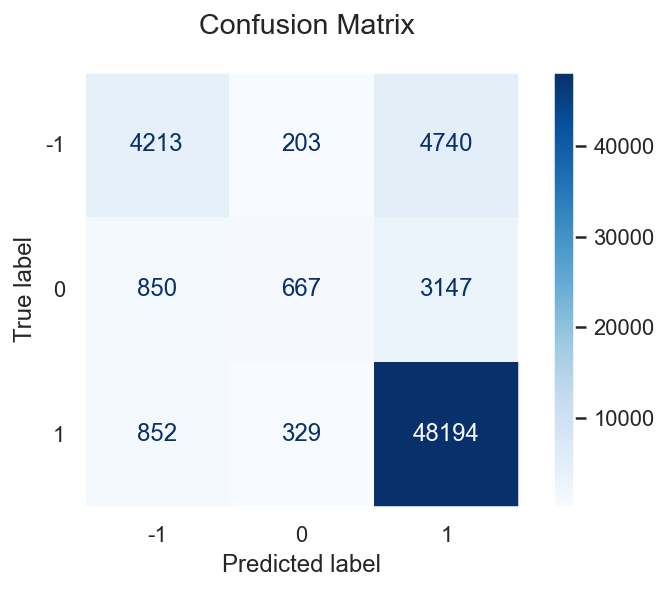

In [22]:
model = linear_model.SGDClassifier(loss="log")
model.fit(x_train_summary, y_train)
evaluate_model(model, x_valid_summary, y_valid)


We can see that baseline model mostly confused about nutral reviews, they they usually missclassified as positive, less - negative

## Baseline Model with `Text` Reviews

Split the data into train (80%) and validation sets (20%)

In [23]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text, cln_df.sentiment, test_size=0.2, random_state=1
)

In [24]:
# count vectorizer:
vectorizer = CountVectorizer()  # token_pattern=r"\b\w+\b"

x_train_text = vectorizer.fit_transform(text_train)
x_valid_text = vectorizer.transform(text_valid)


              precision    recall  f1-score   support

          -1       0.71      0.67      0.69      9113
           0       0.47      0.14      0.21      4797
           1       0.89      0.97      0.93     49286

    accuracy                           0.86     63196
   macro avg       0.69      0.59      0.61     63196
weighted avg       0.84      0.86      0.84     63196



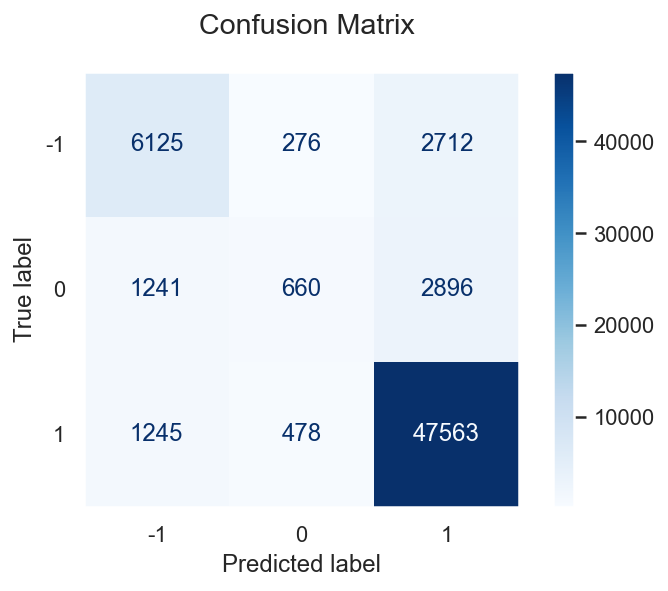

In [25]:
model = linear_model.SGDClassifier(loss="log")
model.fit(x_train_text, y_train)
evaluate_model(model, x_valid_text, y_valid)


### TF-IDF


In [87]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text, cln_df.sentiment, test_size=0.2, random_state=1
)

# count vectorizer:
vectorizer = TfidfVectorizer(stop_words="english")  # token_pattern=r"\b\w+\b"

x_train_tfidf = vectorizer.fit_transform(text_train)
x_valid_tfidf = vectorizer.transform(text_valid)


              precision    recall  f1-score   support

          -1       0.81      0.31      0.45      9113
           0       0.62      0.01      0.02      4797
           1       0.82      0.99      0.90     49286

    accuracy                           0.82     63196
   macro avg       0.75      0.44      0.45     63196
weighted avg       0.80      0.82      0.77     63196



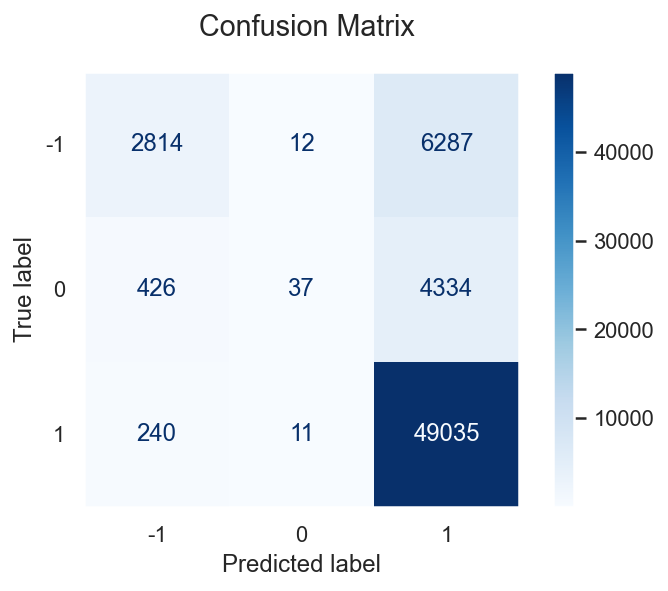

In [88]:
model = linear_model.SGDClassifier(loss="log")
model.fit(x_train_tfidf, y_train)
evaluate_model(model, x_valid_tfidf, y_valid)


### Random undersampling

              precision    recall  f1-score   support

          -1       0.70      0.70      0.70      4939
           0       0.60      0.56      0.58      4680
           1       0.73      0.78      0.75      4710

    accuracy                           0.68     14329
   macro avg       0.68      0.68      0.68     14329
weighted avg       0.68      0.68      0.68     14329



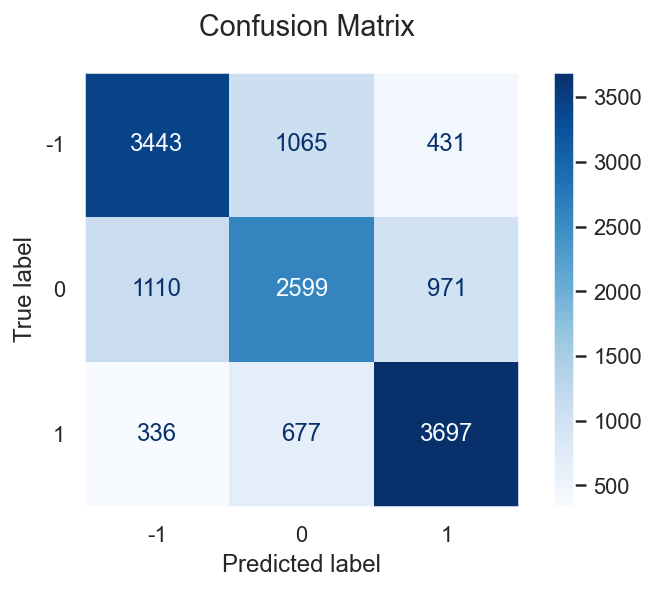

In [96]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

cln_df_balanced, _ = rus.fit_resample(cln_df,cln_df['sentiment'])

text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df_balanced.Text, cln_df_balanced.sentiment, test_size=0.2, random_state=1
)

# count vectorizer:
vectorizer = CountVectorizer(stop_words="english")  # token_pattern=r"\b\w+\b"

x_train_tfidf = vectorizer.fit_transform(text_train)
x_valid_tfidf = vectorizer.transform(text_valid)

model = linear_model.SGDClassifier(loss="log")
model.fit(x_train_tfidf, y_train)
evaluate_model(model, x_valid_tfidf, y_valid)


## Word Embeddings-based Model

**!! Attention !!** the pre-trained Word2Vec model used on Gensim is large (1.6G), so I used the much smaller proposed Glove model instead (128M).

In [28]:
# List of model available on Gensim

for k in gensim_api.info()["models"]:
    print(k)


fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


## Glove embeddings


In [94]:
WV = gensim_api.load("glove-wiki-gigaword-300")


In [95]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)


In [96]:
def vectorize_sentence_bow(words, wv=WV):
    embeddings = []
    for word in words:
        try:
            embeddings.append(wv[word])
        except KeyError:
            pass
    return np.array(embeddings).mean(axis=0)


### Tokenisation and embeddings (!! slow !!)

In [97]:
tokenizer_re = re.compile(r"(?u)\b\w\w+\b")  # r"\w+" r"[\w-]+"

cln_df["words"] = cln_df.Text.str.findall(tokenizer_re)
cln_df["embeddings"] = cln_df.words.progress_map(vectorize_sentence_bow)
cln_df.dropna(inplace=True)


  0%|          | 0/315976 [00:00<?, ?it/s]

C:\Users\Marwa\AppData\Local\Temp/ipykernel_18176/1708626324.py:8: RuntimeWarning:

Mean of empty slice.

C:\Python\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



Split the data into a train (80%) and test sets (20%)

In [101]:
x_train_glove, x_valid_glove, y_train, y_valid = model_selection.train_test_split(
    np.stack(cln_df.embeddings),
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)


              precision    recall  f1-score   support

          -1       0.63      0.38      0.48      9189
           0       0.37      0.01      0.02      4790
           1       0.83      0.97      0.90     48944

    accuracy                           0.81     62923
   macro avg       0.61      0.46      0.46     62923
weighted avg       0.77      0.81      0.77     62923



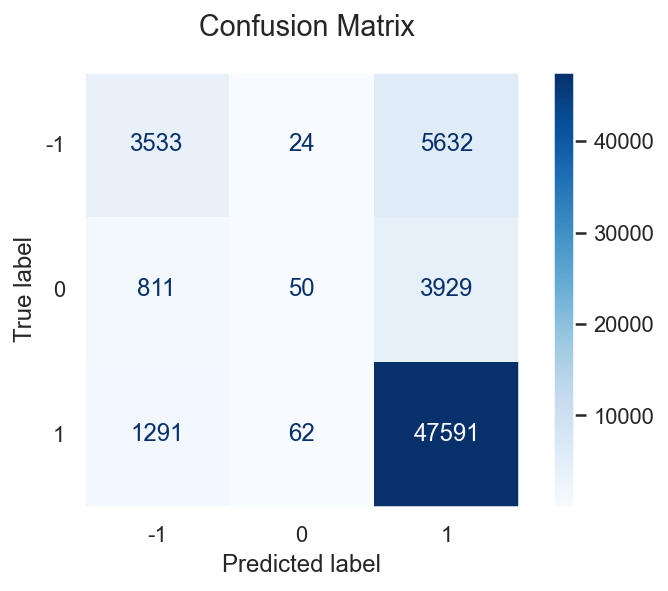

In [102]:
sgd_glove = linear_model.SGDClassifier(loss="log")
sgd_glove.fit(x_train_glove, y_train)
evaluate_model(sgd_glove, x_valid_glove, y_valid)


In [98]:
# visualize 3D pca features using Plotly


def plot_pca_3D(x_train, y_train, limit=100):

    pca = PCA(n_components=3)
    pca.fit(x_train)
    train_features_pca = pca.transform(x_train)
    print("Explained variance ratio: {}".format(np.sum(pca.explained_variance_ratio_)))

    # get index of 0 in y_train_chunks
    # index_m = np.where(y_train_chunks == 0)

    class_1_features = train_features_pca[np.where(y_train == -1)][:limit]
    class_2_features = train_features_pca[np.where(y_train == 0)][:limit]
    class_3_features = train_features_pca[np.where(y_train == 1)][:limit]

    # Plot the 3D PCA features.
    trace_1 = go.Scatter3d(
        x=class_1_features[:, 0],
        y=class_1_features[:, 1],
        z=class_1_features[:, 2],
        mode="markers",
        # legend for y_train_chunks
        marker=dict(size=5, color=-1, colorscale="Viridis", opacity=0.8),
        name="Class -1",
    )

    trace_2 = go.Scatter3d(
        x=class_2_features[:, 0],
        y=class_2_features[:, 1],
        z=class_2_features[:, 2],
        mode="markers",
        # legend for y_train_chunks
        marker=dict(size=5, color=0, colorscale="Viridis", opacity=0.8),
        name="Class 0",
    )

    trace_3 = go.Scatter3d(
        x=class_3_features[:, 0],
        y=class_3_features[:, 1],
        z=class_3_features[:, 2],
        mode="markers",
        # legend for y_train_chunks
        marker=dict(size=5, color=1, colorscale="Viridis", opacity=0.8),
        name="Class 1",
    )

    data = [trace_1, trace_2, trace_3]
    layout = go.Layout(margin=dict(l=50, r=500, b=50, t=50))
    # show legend on the plot
    layout["showlegend"] = True
    layout["scene"]["xaxis"].update(title="PCA 1")
    layout["scene"]["yaxis"].update(title="PCA 2")
    layout["scene"]["zaxis"].update(title="PCA 3")

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


# Visualize with t-SNE features
def plot_tSNE_3D(x_train, y_train, limit=500, n_iter=3000):

    tsne = TSNE(n_components=2, n_iter=n_iter, learning_rate="auto")
    tsne_features = tsne.fit_transform(x_train)
    # get index of 0 in y_train_chunks
    # index_m = np.where(y_train_chunks == 0)
    class_1_features = tsne_features[np.where(y_train == -1)][:limit]
    class_2_features = tsne_features[np.where(y_train == 0)][:limit]
    class_3_features = tsne_features[np.where(y_train == 1)][:limit]
    # Plot the 3D PCA features.
    trace_1 = go.Scatter(
        x=class_1_features[:, 0],
        y=class_1_features[:, 1],
        mode="markers",
        # legend for y_train_chunks
        marker=dict(size=5, color=-1, colorscale="Viridis", opacity=0.8),
        name="Class -1",
    )

    trace_2 = go.Scatter(
        x=class_2_features[:, 0],
        y=class_2_features[:, 1],
        mode="markers",
        # legend for y_train_chunks
        marker=dict(size=5, color=0, colorscale="Viridis", opacity=0.8),
        name="Class 0",
    )

    trace_3 = go.Scatter(
        x=class_3_features[:, 0],
        y=class_3_features[:, 1],
        mode="markers",
        # legend for y_train_chunks
        marker=dict(size=5, color=1, colorscale="Viridis", opacity=0.8),
        name="Class 1",
    )

    data = [trace_1, trace_2, trace_3]
    layout = go.Layout(margin=dict(l=50, r=500, b=50, t=50))
    # show legend on the plot
    layout["showlegend"] = True
    layout["scene"]["xaxis"].update(title="PCA 1")
    layout["scene"]["yaxis"].update(title="PCA 2")

    fig = go.Figure(data=data, layout=layout)
    fig.show()


In [36]:
plot_pca_3D(x_train_glove, y_train)

Explained variance ratio: 0.29102040137279317


In [37]:
plot_tSNE_3D(x_train_glove, y_train, n_iter=500)

/Users/nkise/miniforge3/envs/uni-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



---

## Word2Vec embeddings

In [90]:
WV_word2vec = gensim_api.load("word2vec-google-news-300")


In [99]:
cln_df["embeddings_word2vec"] = cln_df.words.progress_map(
    vectorize_sentence_bow, WV_word2vec
)
cln_df.dropna(inplace=True)

x_train_word2vec, x_valid_word2vec, y_train, y_valid = model_selection.train_test_split(
    np.stack(cln_df.embeddings_word2vec),
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)


  0%|          | 0/314611 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          -1       0.63      0.39      0.48      9189
           0       0.35      0.01      0.01      4790
           1       0.83      0.97      0.90     48944

    accuracy                           0.81     62923
   macro avg       0.60      0.46      0.46     62923
weighted avg       0.77      0.81      0.77     62923



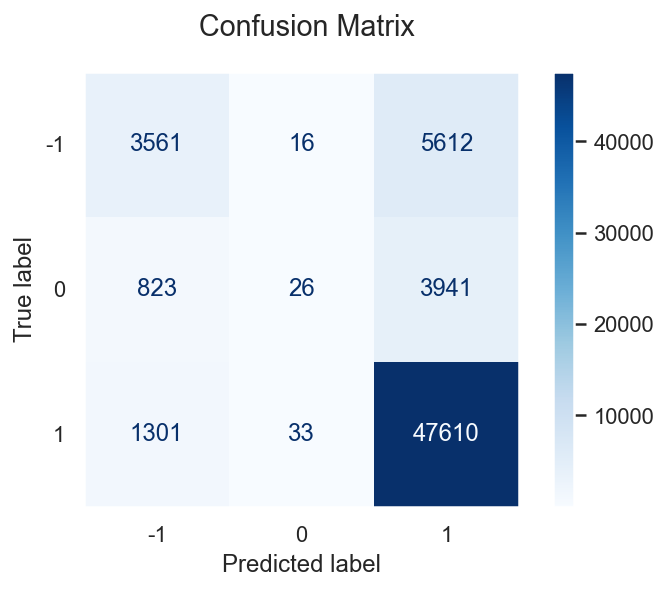

In [36]:
sgd_word2vec = linear_model.SGDClassifier(loss="log")
sgd_word2vec.fit(x_train_word2vec, y_train)
evaluate_model(sgd_word2vec, x_valid_word2vec, y_valid)


In [39]:
plot_pca_3D(x_train_word2vec, y_train)


Explained variance ratio: 0.29100043931987385


In [134]:
plot_tSNE_3D(x_train_word2vec, y_train, n_iter=500)

C:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



## FastText embeddings



In [41]:
WV_fastText = gensim_api.load("fasttext-wiki-news-subwords-300")


In [42]:
cln_df["embeddings_fastText"] = cln_df.words.progress_map(
    vectorize_sentence_bow, WV_fastText
)
cln_df.dropna(inplace=True)

x_train_fastText, x_valid_fastText, y_train, y_valid = model_selection.train_test_split(
    np.stack(cln_df.embeddings_fastText),
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)


  0%|          | 0/314611 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          -1       0.62      0.41      0.49      9189
           0       0.35      0.01      0.02      4790
           1       0.84      0.97      0.90     48944

    accuracy                           0.81     62923
   macro avg       0.60      0.46      0.47     62923
weighted avg       0.77      0.81      0.77     62923



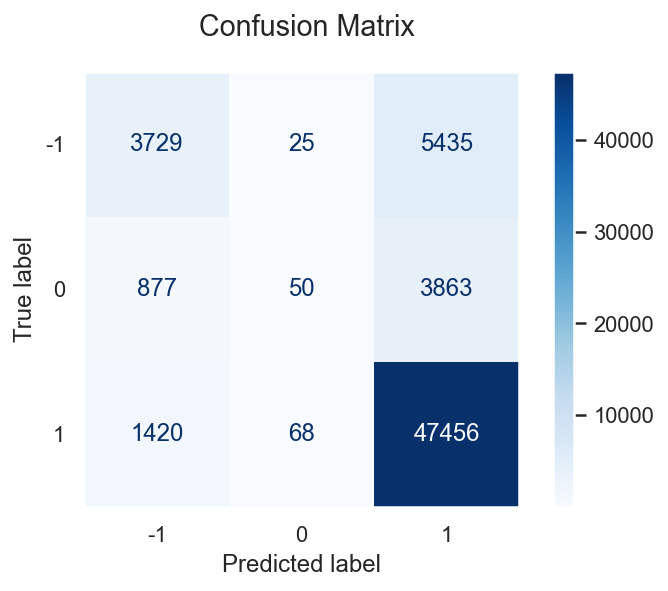

Explained variance ratio: 0.2910004123076236


In [43]:
sgd_fastText = linear_model.SGDClassifier(loss="log")
sgd_fastText.fit(x_train_fastText, y_train)
evaluate_model(sgd_fastText, x_valid_fastText, y_valid)
plot_pca_3D(x_train_fastText, y_train)


---

## Part 2: 🤝 BERT + Sentiment analysis

In [17]:
from transformers import (
    BertModel,
    BertTokenizer,
    DistilBertModel,
    DistilBertTokenizer,
    DistilBertTokenizerFast,
)

import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from torch.utils.data import Dataset


In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device


'cuda:0'

In [21]:
model_class, tokenizer_class = DistilBertModel, DistilBertTokenizerFast
pretrained_weights = "distilbert-base-uncased"

## Want BERT instead of distilBERT? Uncomment the following line:
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Try tokenizer and model on one sample

In [22]:
test = train_df.Text[2]
tok_text = tokenizer.encode_plus(
    test,
    add_special_tokens=True,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt",
).to(device)


Here you can observe the behaviour of **WordPiece** tokenizer

In [23]:
with open("./honlp-project/vocab.txt", "r") as fp:
    vocab = fp.read().split("\n")


In [24]:
ids_list = tokenizer(train_df.Text[0]).input_ids
vocab_list = []
for id in ids_list:
    vocab_list.append(vocab[id])

print(vocab_list)


['[CLS]', 'i', 'have', 'bought', 'several', 'of', 'the', 'vital', '##ity', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', '.', 'my', 'labrador', 'is', 'fin', '##ick', '##y', 'and', 'she', 'appreciate', '##s', 'this', 'product', 'better', 'than', 'most', '.', '[SEP]']


In [31]:
with torch.no_grad():
    last_hidden_states = model(**tok_text)


In [32]:
features = last_hidden_states[0][:, 0, :].cpu().numpy()
features.shape


(1, 768)

### Extract features and train simple sentiment classifier

For this code you need GPU with at least 8GB of memory. Use Kaggle or Colab. 

In [19]:
# Extract text and label from the dataframe.
cln_df = train_df[["Text", "sentiment"]].copy()
# Drop rows with missing values.
cln_df.dropna(subset=["Text"], inplace=True)
cln_df.reset_index(drop=True, inplace=True)
cln_df.head(5)


,Text,sentiment
0,Truvia gives very close to the 'sweetness' tha...,1
1,Luzianne Coffee is the best Coffee I have ever...,1
2,I found this flavor of Primal Strips Spicy & (...,-1
3,Wanted something that is pretty much hassle fr...,1
4,I started taking this when my baby was about 1...,0


In [20]:
cln_df_test = test_df[["Text", "sentiment"]].copy()
cln_df_test.dropna(subset=["Text"], inplace=True)
cln_df_test.reset_index(drop=True, inplace=True)
cln_df_test.head(5)


,Text,sentiment
0,Tried for a few years to obtain gooseberries b...,1
1,"If it's curry, chances are pretty great that I...",1
2,A friend bought me this product because I love...,1
3,"The product was the same, but it came in a pla...",1
4,This is a great product which I have chosen to...,1


In [21]:
## Split to train and validation sets.
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text,
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)


In [22]:
x_test, y_test = cln_df_test.Text, cln_df_test.sentiment

In [23]:
## Here we take only 30% of train and validation data, to make embeddins extraction faster.
PERCENTAGE_SIZE = 0.3
BATCH_SIZE = 250


In [24]:
# Take 20% to reduce computation time.
train_chunks = [
    x_train[i : i + BATCH_SIZE]
    for i in range(0, int(x_train.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
valid_chunks = [
    x_valid[i : i + BATCH_SIZE]
    for i in range(0, int(x_valid.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
test_chunks = [
    x_test[i : i + BATCH_SIZE] for i in range(0, int(x_test.shape[0]), BATCH_SIZE)
]


In [25]:
# Take 20% of labels
y_train_chunks = [
    y_train[i : i + BATCH_SIZE]
    for i in range(0, int(y_train.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
y_valid_chunks = [
    y_valid[i : i + BATCH_SIZE]
    for i in range(0, int(y_valid.shape[0] * PERCENTAGE_SIZE), BATCH_SIZE)
]
y_test_chunks = [
    y_test[i : i + BATCH_SIZE] for i in range(0, int(y_test.shape[0]), BATCH_SIZE)
]

y_train_chunks = np.concatenate(y_train_chunks)
y_valid_chunks = np.concatenate(y_valid_chunks)
y_test_chunks = np.concatenate(y_test_chunks)


Extract train data features

In [ ]:
train_features = []
# list_input_ids = []
# list_attention_mask = []
for chunk in tqdm.tqdm(train_chunks):
    tok_text = tokenizer.batch_encode_plus(
        chunk.tolist(),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    # list_input_ids.append(tok_text["input_ids"])
    # list_attention_mask.append(tok_text["attention_mask"])

    tok_text = tok_text.to(device)
    with torch.no_grad():
        last_hidden_states = model(**tok_text)

    features = last_hidden_states[0][:, 0, :].cpu().numpy()
    train_features.append(features)


train_features = np.concatenate(train_features)
# list_input_ids = np.concatenate(list_input_ids)
# list_attention_mask = np.concatenate(list_attention_mask)
train_features.shape


Extract validation data features

In [ ]:
valid_features = []
# list_input_ids = []
# list_attention_mask = []
for chunk in tqdm.tqdm(valid_chunks):
    tok_text = tokenizer.batch_encode_plus(
        chunk.tolist(),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    tok_text = tok_text.to(device)
    with torch.no_grad():
        last_hidden_states = model(**tok_text)

    features = last_hidden_states[0][:, 0, :].cpu().numpy()
    valid_features.append(features)


valid_features = np.concatenate(valid_features)
# list_input_ids = np.concatenate(list_input_ids)
# list_attention_mask = np.concatenate(list_attention_mask)
valid_features.shape


... and test set

In [ ]:
test_features = []
# list_input_ids = []
# list_attention_mask = []
for chunk in tqdm.tqdm(test_chunks):
    tok_text = tokenizer.batch_encode_plus(
        chunk.tolist(),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    tok_text = tok_text.to(device)
    with torch.no_grad():
        last_hidden_states = model(**tok_text)

    features = last_hidden_states[0][:, 0, :].cpu().numpy()
    test_features.append(features)


test_features = np.concatenate(test_features)
# list_input_ids = np.concatenate(list_input_ids)
# list_attention_mask = np.concatenate(list_attention_mask)
test_features.shape


Save them in numpy data format

In [ ]:
np.save("train_features.npy", train_features)
np.save("valid_features.npy", valid_features)
np.save("test_features.npy", test_features)


## Train classification models

### Load embeddings

In [26]:
# load train and validation features
train_features = np.load("train_features.npy")
valid_features = np.load("valid_features.npy")
test_features = np.load("test_features.npy")

train_features_summary = np.load("train_features_summary.npy")
valid_features_summary = np.load("valid_features_summary.npy")
test_features_summary = np.load("test_features_summary.npy")


#### Logistic regression

/Users/nkise/miniforge3/envs/uni-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

          -1       0.69      0.66      0.67      2754
           0       0.44      0.15      0.22      1422
           1       0.89      0.96      0.93     14824

    accuracy                           0.85     19000
   macro avg       0.68      0.59      0.61     19000
weighted avg       0.83      0.85      0.84     19000



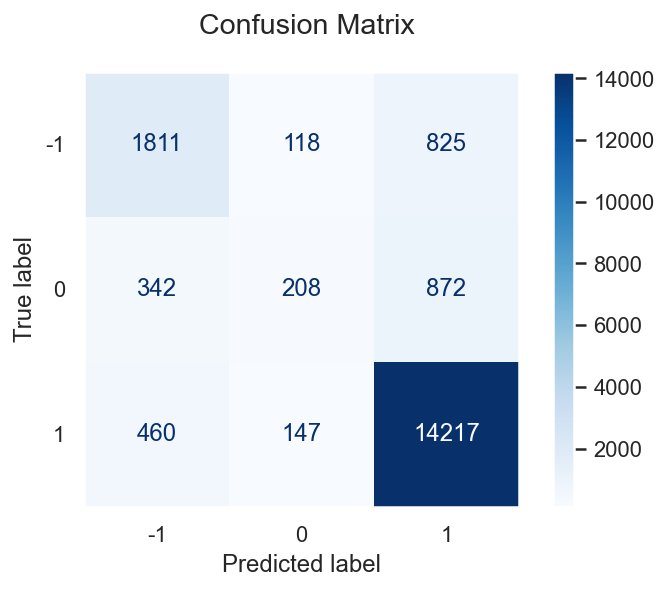

In [67]:
## Train a model on the training features.

train_features = train_features.reshape(train_features.shape[0], -1)
valid_features = valid_features.reshape(valid_features.shape[0], -1)

clf_bert_logistic_text = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=100
)
clf_bert_logistic_text.fit(train_features, y_train_chunks)
evaluate_model(clf_bert_logistic_text, valid_features, y_valid_chunks)


#### SGDClassifier

In [68]:
clf_bert_sgd = linear_model.SGDClassifier()
clf_bert_sgd.fit(train_features, y_train_chunks)


SGDClassifier()

In [69]:
from sklearn.metrics import classification_report

preds = clf_bert_sgd.predict(valid_features)
print(classification_report(y_valid_chunks, preds))


              precision    recall  f1-score   support

          -1       0.69      0.69      0.69      2754
           0       0.46      0.00      0.01      1422
           1       0.89      0.97      0.93     14824

    accuracy                           0.86     19000
   macro avg       0.68      0.55      0.54     19000
weighted avg       0.83      0.86      0.82     19000



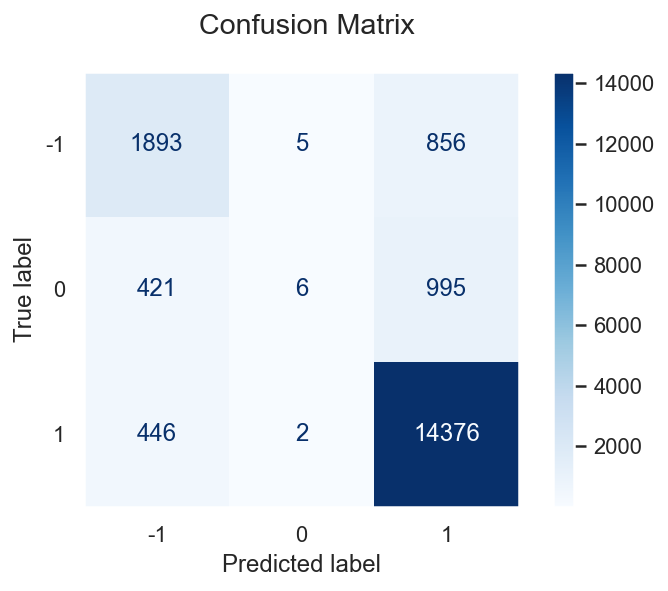

In [70]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    clf_bert_sgd, valid_features, y_valid_chunks, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()


#### PCA dimensionality reduction + RandomForest

In [71]:
# Reduce dimensionality with PCA. Reduce train and validation features.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA


Firsly, we tried different n_components for PCA dimensionality reduction. Then, we chose the best one with the best f1-score and trained bigger RandomForest model.

In [72]:
# For different n_components of PCA, train and validate the model.
f1_scores = []
pca_components = [30, 50, 100, 200, 400, 500, 600, 768]
clf_bert_tree = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
for i in pca_components:
    pca = PCA(n_components=i)
    pca.fit(train_features)

    train_features_pca = pca.transform(train_features)
    valid_features_pca = pca.transform(valid_features)

    clf_bert_tree.fit(train_features_pca, y_train_chunks)

    preds = clf_bert_tree.predict(valid_features_pca)
    print(f1_score(y_valid_chunks, preds, average="macro"))

    f1_scores.append(f1_score(y_valid_chunks, preds, average="macro"))


0.4541566295525514
0.44074028006728394
0.40294552903399805
0.3577458137443392
0.3213297652323792
0.3098756814718643
0.30708883900084577
0.29936940321083105


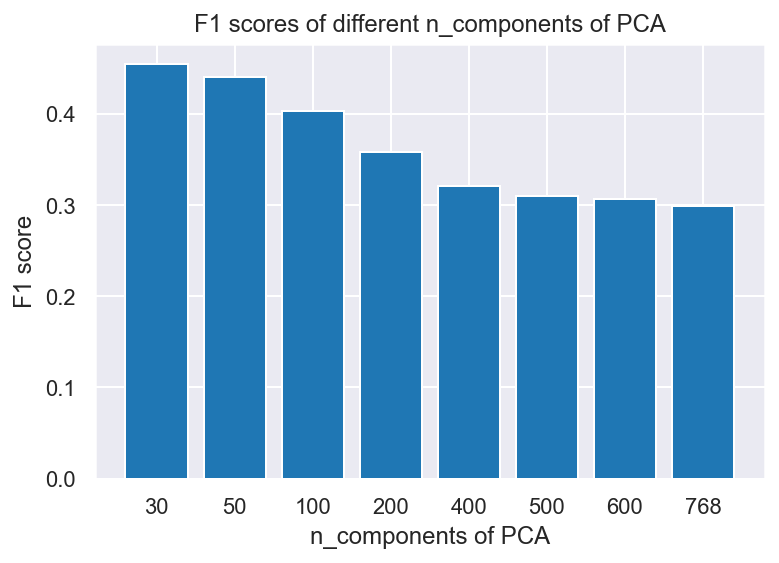

In [73]:
# plot f1_scores bar plot
plt.bar(range(len(f1_scores)), f1_scores)
plt.xticks(range(len(f1_scores)), pca_components)
plt.title("F1 scores of different n_components of PCA")
plt.xlabel("n_components of PCA")
plt.ylabel("F1 score")
plt.grid(True)
plt.show()


Train on the best n_components value

              precision    recall  f1-score   support

          -1       0.69      0.43      0.53      2754
           0       0.43      0.00      0.01      1422
           1       0.84      0.98      0.90     14824

    accuracy                           0.83     19000
   macro avg       0.65      0.47      0.48     19000
weighted avg       0.79      0.83      0.78     19000

PCA Explained variance ratio: 0.7058328428787047


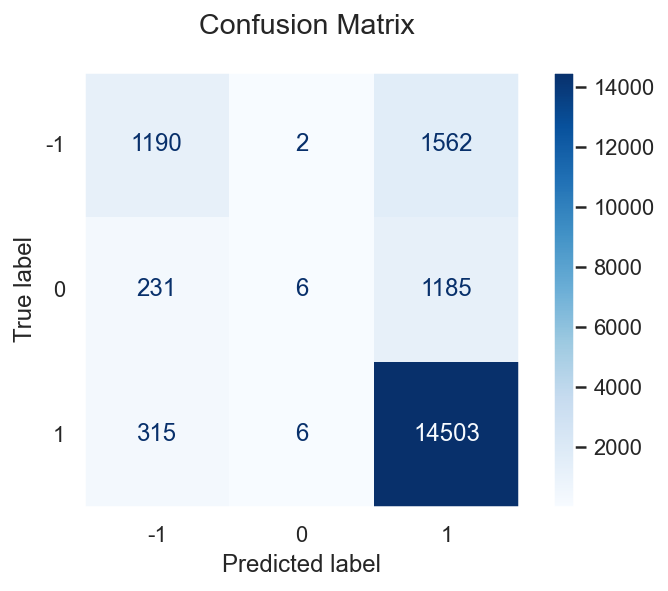

In [75]:
pca = PCA(n_components=30)

pca.fit(train_features)

train_features_pca = pca.transform(train_features)
valid_features_pca = pca.transform(valid_features)

# Train a  Random Forest model on the reduced features.
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, max_features=20, random_state=0)

# Fit the model on the reduced features.
clf.fit(train_features_pca, y_train_chunks)

## Create classification report
from sklearn.metrics import classification_report

preds = clf.predict(valid_features_pca)
print(classification_report(y_valid_chunks, preds))
print("PCA Explained variance ratio: {}".format(np.sum(pca.explained_variance_ratio_)))

# Display the confusion matrix.
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    clf, valid_features_pca, y_valid_chunks, cmap=plt.cm.Blues
)

disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()


### 🖼 Visualize features in PCA reduced 3D space

In [76]:
# visualize 3D pca features using Plotly
from plotly.offline import iplot
import plotly.graph_objs as go

pca = PCA(n_components=3)
pca.fit(train_features)
train_features_pca = pca.transform(train_features)
print("Explained variance ratio: {}".format(np.sum(pca.explained_variance_ratio_)))


Explained variance ratio: 0.2384945125130077


In [77]:
# get index of 0 in y_train_chunks
# index_m = np.where(y_train_chunks == 0)
class_1_features = train_features_pca[np.where(y_train_chunks == -1)[0][:100]]
class_2_features = train_features_pca[np.where(y_train_chunks == 0)[0][:100]]
class_3_features = train_features_pca[np.where(y_train_chunks == 1)[0][:100]]


In [83]:
plot_pca_3D(train_features_pca, y_train_chunks)

Explained variance ratio: 1.0


### 🖼 Visualize features in t-SNE reduced 3D space

In [80]:
# Visualize with t-SNE features
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000, learning_rate="auto")
tsne_features = tsne.fit_transform(train_features)


/Users/nkise/miniforge3/envs/uni-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [81]:
# get index of 0 in y_train_chunks
# index_m = np.where(y_train_chunks == 0)
class_1_features = tsne_features[np.where(y_train_chunks == -1)[0][:500]]
class_2_features = tsne_features[np.where(y_train_chunks == 0)[0][:500]]
class_3_features = tsne_features[np.where(y_train_chunks == 1)[0][:500]]


In [82]:
# Plot the 3D PCA features.
trace_1 = go.Scatter(
    x=class_1_features[:, 0],
    y=class_1_features[:, 1],
    mode="markers",
    # legend for y_train_chunks
    marker=dict(size=5, color=-1, colorscale="Viridis", opacity=0.8),
    name="Class -1",
)

trace_2 = go.Scatter(
    x=class_2_features[:, 0],
    y=class_2_features[:, 1],
    mode="markers",
    # legend for y_train_chunks
    marker=dict(size=5, color=0, colorscale="Viridis", opacity=0.8),
    name="Class 0",
)

trace_3 = go.Scatter(
    x=class_3_features[:, 0],
    y=class_3_features[:, 1],
    mode="markers",
    # legend for y_train_chunks
    marker=dict(size=5, color=1, colorscale="Viridis", opacity=0.8),
    name="Class 1",
)

data = [trace_1, trace_2, trace_3]
layout = go.Layout(margin=dict(l=50, r=500, b=50, t=50))
# show legend on the plot
layout["showlegend"] = True
layout["scene"]["xaxis"].update(title="PCA 1")
layout["scene"]["yaxis"].update(title="PCA 2")

fig = go.Figure(data=data, layout=layout)
fig.show()


## Back to logistic regression

Increase the max number of estimators to 2000

              precision    recall  f1-score   support

          -1       0.70      0.67      0.69      2754
           0       0.44      0.16      0.24      1422
           1       0.90      0.96      0.93     14824

    accuracy                           0.86     19000
   macro avg       0.68      0.60      0.62     19000
weighted avg       0.84      0.86      0.84     19000



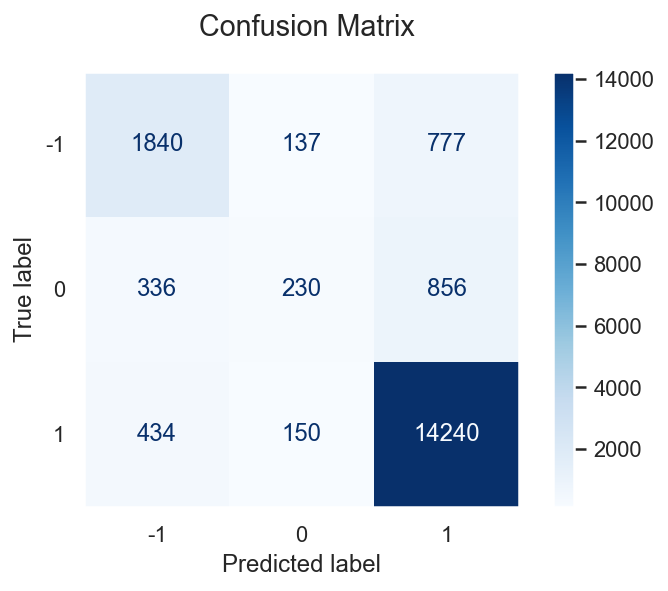

In [156]:
train_features = train_features.reshape(train_features.shape[0], -1)
valid_features = valid_features.reshape(valid_features.shape[0], -1)

clf_bert_logistic_text = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=2000
)
clf_bert_logistic_text.fit(train_features, y_train_chunks)
evaluate_model(clf_bert_logistic_text, valid_features, y_valid_chunks)


### Try with the summary

              precision    recall  f1-score   support

          -1       0.69      0.63      0.66      2754
           0       0.50      0.17      0.25      1422
           1       0.89      0.96      0.93     14824

    accuracy                           0.85     19000
   macro avg       0.69      0.59      0.61     19000
weighted avg       0.83      0.85      0.84     19000



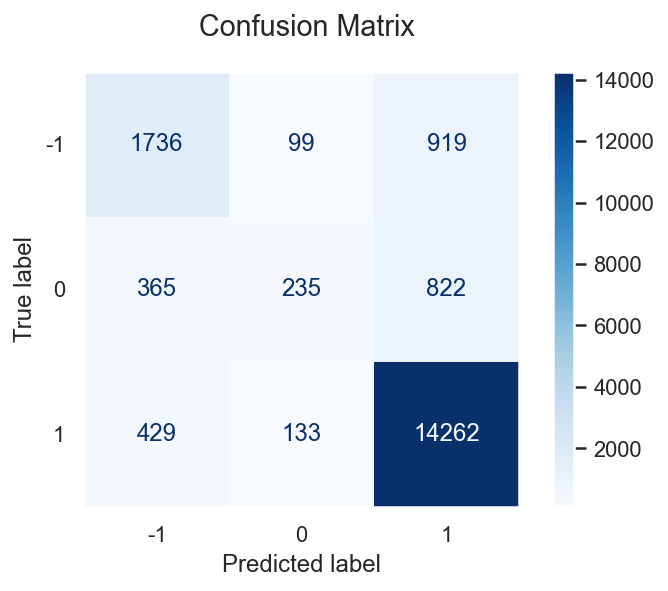

In [160]:
clf_bert_logistic_summary = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=2000
)
clf_bert_logistic_summary.fit(train_features_summary, y_train_chunks)
evaluate_model(clf_bert_logistic_summary, valid_features_summary, y_valid_chunks)


### Stack both summary and text 

In [27]:
train_stacked = np.concatenate([train_features_summary,train_features],axis=1)
valid_stacked = np.concatenate([valid_features_summary,valid_features],axis=1)

print(train_stacked.shape,valid_stacked.shape)

(76000, 1536) (19000, 1536)


              precision    recall  f1-score   support

          -1       0.75      0.76      0.76      2754
           0       0.50      0.28      0.36      1422
           1       0.93      0.96      0.94     14824

    accuracy                           0.88     19000
   macro avg       0.73      0.67      0.69     19000
weighted avg       0.87      0.88      0.87     19000



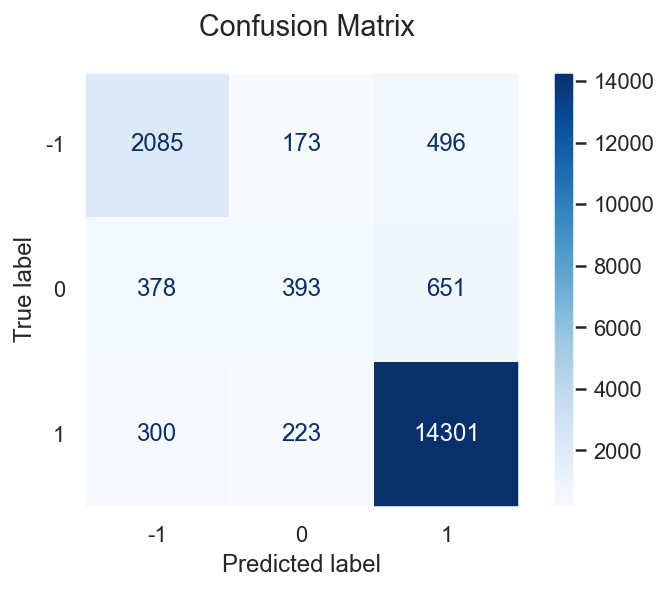

Wall time: 9min 12s


In [28]:
%%time
clf_bert_logistic_stacked = LogisticRegression(
    solver="lbfgs", multi_class="multinomial", max_iter=2000
)
clf_bert_logistic_stacked.fit(train_stacked, y_train_chunks)
evaluate_model(clf_bert_logistic_stacked, valid_stacked, y_valid_chunks)

---

## Part 3: ⏳ BERT fine-tuning

In this part we will fine-tune BERT classifier to improve the performance of the model. Instead of training dedicatede classifier on the extracted features, we apply classification layer on top of BERT. Then, the whole constructed model is fine-tuned, including the BERT weights.  

🚧 To run this code, you **need to use GPU instance** with at least 8GB of memory. Use Kaggle or Colab for free GPU instances. Estimated running time **~2 hours.** 🚧  

You can skip this step, and go directly to the Validation part. Pre-trained weights can be downloaded from the [HERE](https://drive.google.com/drive/folders/1USA00v7G8x1jZqrxsXEPV04vGQCnq8uv?usp=sharing)
 

### Training part

In [ ]:
from transformers import DataCollatorWithPadding, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
# Extract text and label from the dataframe.
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)
cln_df.reset_index(drop=True, inplace=True)


In [ ]:
## Split to train and validation sets.
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text,
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)
x_train.shape, y_train.shape


In [ ]:
# UnderSampling of the x_train and y_train
rus = RandomUnderSampler(
    random_state=0, sampling_strategy={-1: 25000, 0: 19084, 1: 50000}
)
x_train, y_train = rus.fit_resample(
    np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
)


(array([25000., 19084., 50000.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

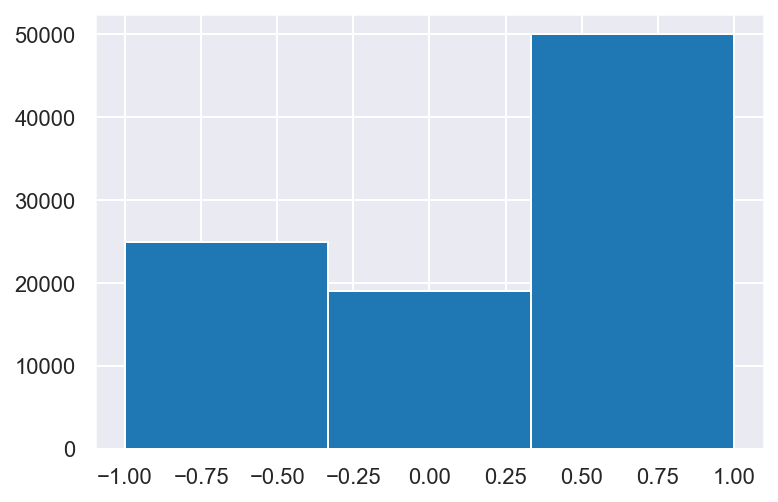

In [ ]:
# plot histogram of y_train
plt.hist(y_train, bins=3)


Here we transform data to list.

In [ ]:
VAL_DATA_DIVIDER = 10

x_train = x_train.reshape(-1).tolist()[:]
x_valid = x_valid.values.tolist()[: len(x_valid) // VAL_DATA_DIVIDER]

y_train = y_train.reshape(-1).tolist()[:]
y_valid = y_valid.values.tolist()[: len(y_valid) // VAL_DATA_DIVIDER]

len(x_train), len(x_valid), len(y_train), len(y_valid)


Initialize BERT Classifier model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3
)


Tokenize the data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
x_train_tok = tokenizer(x_train, truncation=True, padding=True, max_length=512)
x_valid_tok = tokenizer(x_valid, truncation=True, padding=True, max_length=512)


Define the class for input Dataset. We need to use it as a loader of data into PyTorch model.  
Also, to track metrics during validation steps, we need to define them as a dedicated function

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx] + 1)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


train_dataset = Dataset(x_train_tok, y_train)
val_dataset = Dataset(x_valid_tok, y_valid)


In [ ]:
# Validation metrics function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro")
    precision = precision_score(y_true=labels, y_pred=pred, average="macro")
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


Finally, we define the training hyperparameters. To simplify training process, we used `Trainer` class from the transormers library.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=0,
    evaluation_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)


⌛️ Finally, run the training process

In [1]:
trainer.train()


### Validation part

Load model from saved weights

In [ ]:
# Load trained model
model_path = "./results/checkpoint-8000"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)

# Define test trainer
test_trainer = Trainer(model)


Run prediction on validation set

In [ ]:
# Validation data
raw_pred, _, _ = test_trainer.predict(val_dataset)

y_pred = np.argmax(raw_pred, axis=1)


***** Running Prediction *****
  Num examples = 6319
  Batch size = 16


Note! Because fine-tuned model will return classes in the form of probabilities, we need to use `argmax` to get the class label.

Also, these labels will be in [0,1,2] format, so we need to convert them to [-1,0,1] format.

In [ ]:
print(classification_report(y_valid, y_pred - 1))


              precision    recall  f1-score   support

          -1       0.80      0.80      0.80       894
           0       0.42      0.61      0.50       499
           1       0.97      0.93      0.95      4926

    accuracy                           0.89      6319
   macro avg       0.73      0.78      0.75      6319
weighted avg       0.90      0.89      0.89      6319



---

## Part 3: Final test

In this section we will test the our best findings on the test set and compare the results in the Final table

### Prepare data

In [ ]:
cln_df_test = test_df[["Text", "sentiment"]].copy()
cln_df_test.dropna(subset=["Text"], inplace=True)
cln_df_test.reset_index(drop=True, inplace=True)
cln_df_test.head(3)


### Glove embeddings + SGDClassifier

In [ ]:
test_df_copy["words"] = test_df_copy.Text.str.findall(tokenizer_re)
test_df_copy["embeddings"] = test_df_copy.words.progress_map(vectorize_sentence_bow)
test_df_copy.dropna(inplace=True)

              precision    recall  f1-score   support

          -1       0.63      0.38      0.48     11543
           0       0.37      0.01      0.02      5934
           1       0.83      0.97      0.90     61153

    accuracy                           0.81     78630
   macro avg       0.61      0.45      0.46     78630
weighted avg       0.77      0.81      0.77     78630



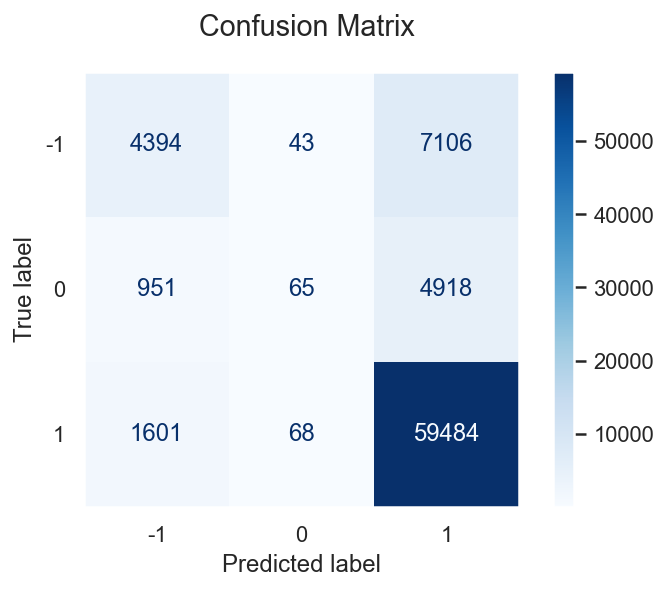

In [ ]:
evaluate_model(sgd_glove, np.stack(test_df_copy['embeddings']), test_df_copy['sentiment'])

### 1. BERT embeddings + SGDClassifier

Load pre-calculated features

In [ ]:
test_features = np.load("./test_features.npy")
test_features = test_features.reshape(test_features.shape[0], -1)


In [ ]:
preds = clf_bert_sgd.predict(test_features)
print(classification_report(y_test, preds))
print("F1 score: ", f1_score(y_test, preds, average="macro"))


#### Final F1 score: **0.566**

### 2. BERT embeddings + LogisticRegression + Stacked features

In [29]:
cln_test = test_df[["Summary","Text", "sentiment"]].copy()
cln_test['test_features'] = test_features.tolist()
cln_test.dropna(subset=["Summary","Text"], inplace=True)
cln_test.reset_index(drop=True, inplace=True)
test_features_cln = np.array([np.array(xi) for xi in cln_test['test_features'].to_numpy()])
test_stacked = np.concatenate([test_features_summary,test_features_cln],axis=1)

              precision    recall  f1-score   support

          -1       0.75      0.76      0.76     11591
           0       0.48      0.27      0.34      5954
           1       0.93      0.96      0.94     61447

    accuracy                           0.88     78992
   macro avg       0.72      0.67      0.68     78992
weighted avg       0.87      0.88      0.87     78992



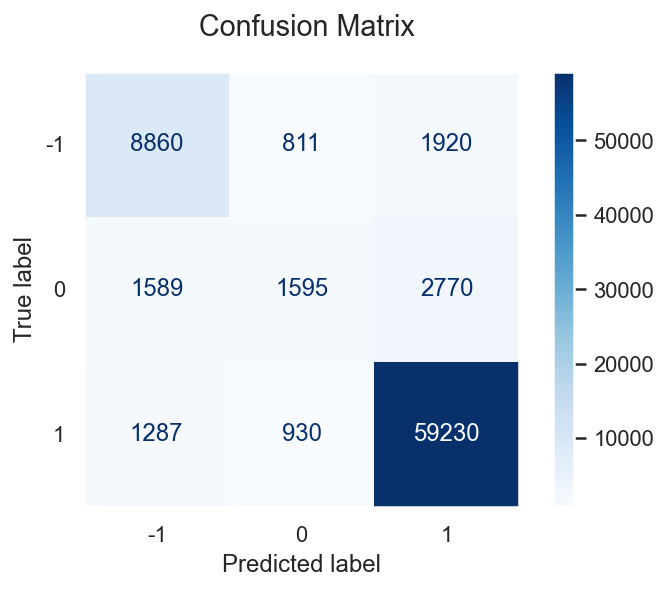

In [33]:
evaluate_model(clf_bert_logistic_stacked, test_stacked, cln_test.sentiment)

### 2. Fine-tuned BERT 

In [ ]:
x_test = cln_df_test.Text.values.tolist()
y_test = cln_df_test.sentiment.values.tolist()


In [ ]:
x_test_tok = tokenizer(x_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(x_test_tok)


In [ ]:
# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)


***** Running Prediction *****
  Num examples = 78994
  Batch size = 16


              precision    recall  f1-score   support

          -1       0.80      0.81      0.81     11591
           0       0.41      0.62      0.49      5956
           1       0.98      0.93      0.95     61447

    accuracy                           0.89     78994
   macro avg       0.73      0.79      0.75     78994
weighted avg       0.91      0.89      0.89     78994



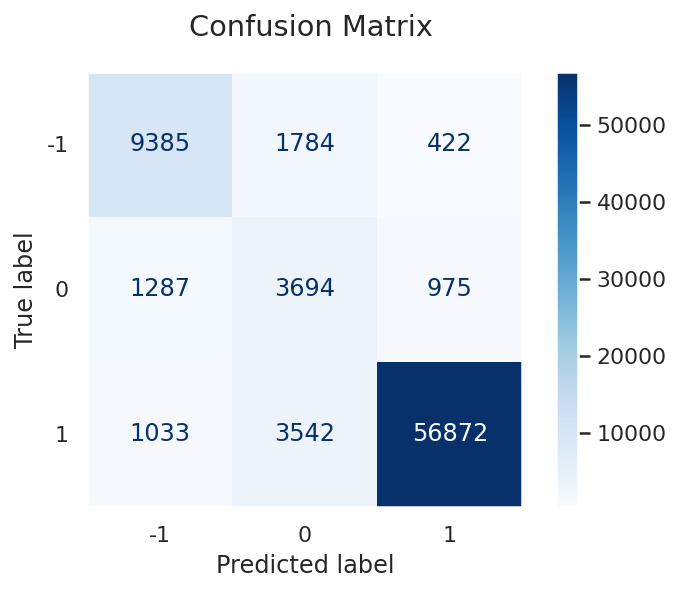

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred - 1))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred - 1, cmap=plt.cm.Blues)

disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()


#### Final F1 score: **0.75**

### Table of results

| Method      | F1 macro avg. |
| ----------- | ----------- |
| Glove embeddings + SGD | 0.46 |
| DistilBERT embeddings + SGD      | 0.566       |
| DistilBERT embeddings + Logistic + stack | 0.69 |
| DistliBERT Fine-tuned   | 0.75        |